# Superconductor Critical Temperature Prediction

This notebook implements an end-to-end workflow including multiple regression models:

- **Linear Models**: LinearRegression, Ridge, Lasso, ElasticNet
- **Kernel Model**: SVR
- **Tree-based Models**: DecisionTreeRegressor, RandomForestRegressor, GradientBoostingRegressor, XGBRegressor, LGBMRegressor

Steps:

1. Setup & Reproducibility
2. Data Loading
3. EDA & Feature Engineering
4. Preprocessing Pipeline
5. Model Definition & Hyperparameter Search
6. Model Training, Evaluation & Comparison
7. Final Results


In [9]:
# 1. SETUP & REPRODUCIBILITY
%pip install scikit-learn lightgbm seaborn xgboost requests
import os
import random
import numpy as np
import pandas as pd

# Fix seeds for reproducibility
os.environ['PYTHONHASHSEED'] = '0'
random.seed(42)
np.random.seed(42)

import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import requests
import zipfile
import io
warnings.filterwarnings("ignore")

# SKLearn imports
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, KFold, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score

# Models
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import lightgbm as lgb
from xgboost import XGBRegressor


## 2. DATA LOADING

Load `train.csv` from UCI Superconductivity.


   number_of_elements  mean_atomic_mass  wtd_mean_atomic_mass  \
0                   4         88.944468             57.862692   
1                   5         92.729214             58.518416   
2                   4         88.944468             57.885242   
3                   4         88.944468             57.873967   
4                   4         88.944468             57.840143   

   gmean_atomic_mass  wtd_gmean_atomic_mass  entropy_atomic_mass  \
0          66.361592              36.116612             1.181795   
1          73.132787              36.396602             1.449309   
2          66.361592              36.122509             1.181795   
3          66.361592              36.119560             1.181795   
4          66.361592              36.110716             1.181795   

   wtd_entropy_atomic_mass  range_atomic_mass  wtd_range_atomic_mass  \
0                 1.062396          122.90607              31.794921   
1                 1.057755          122.90607           

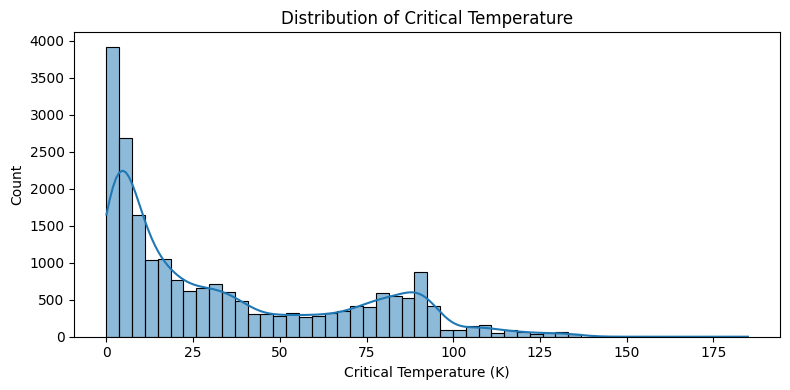

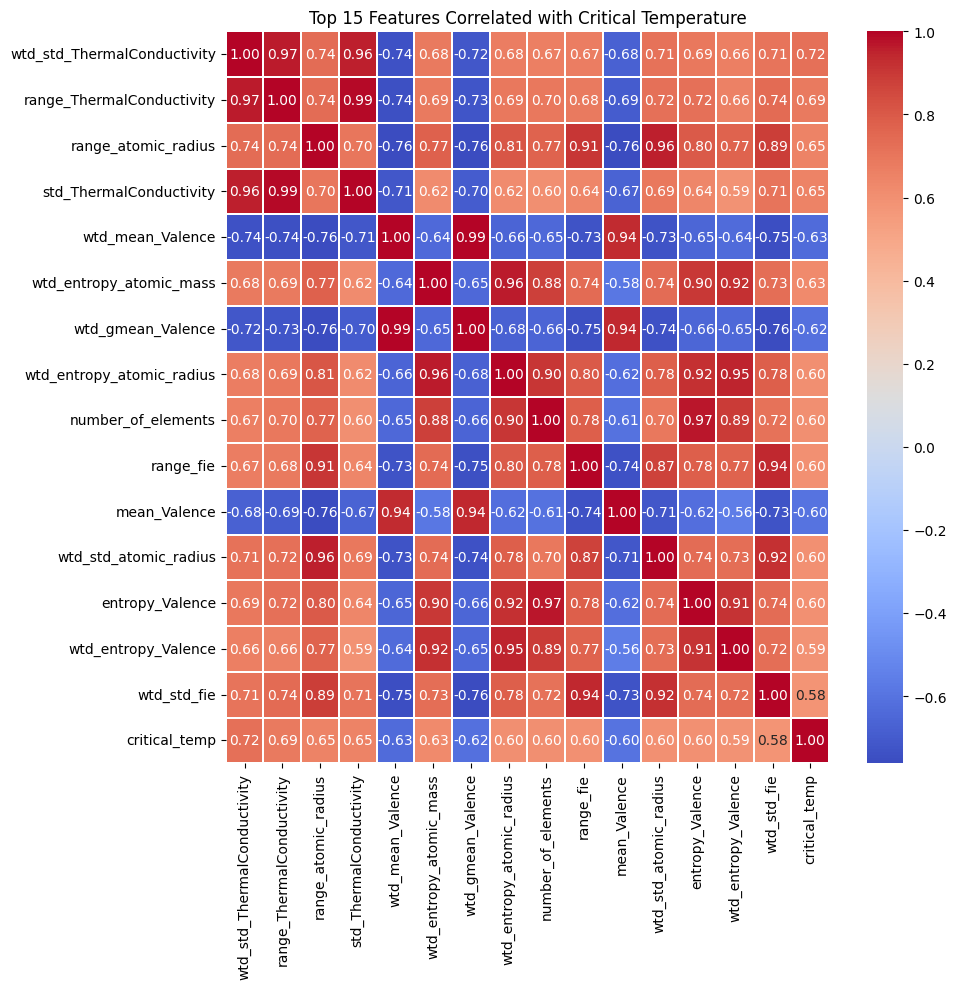

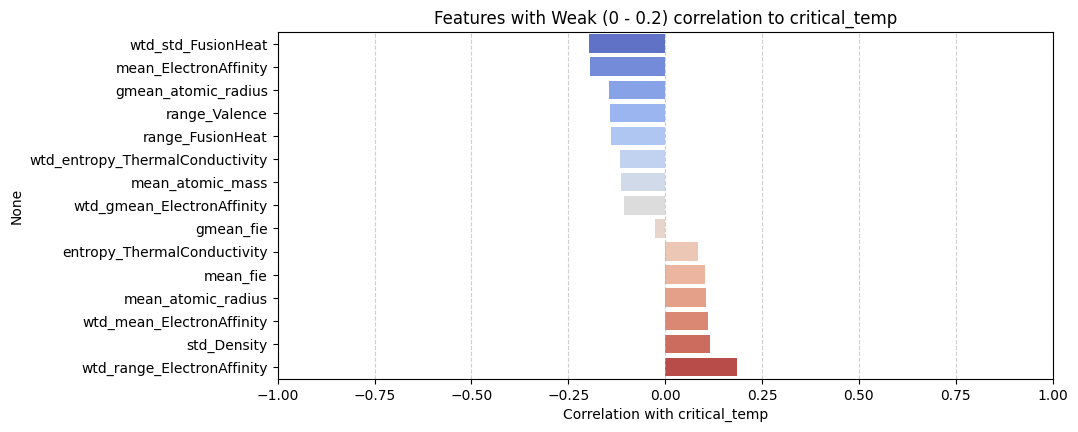

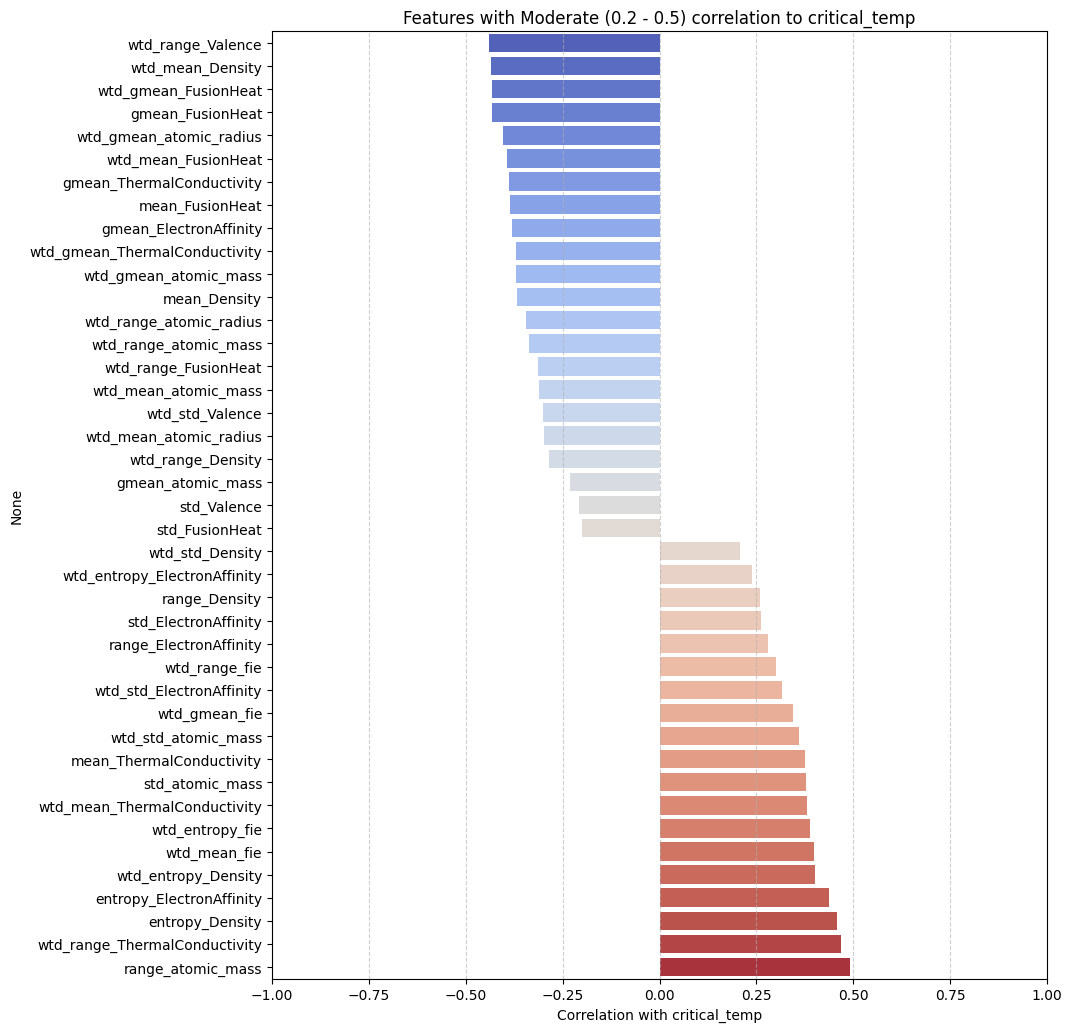

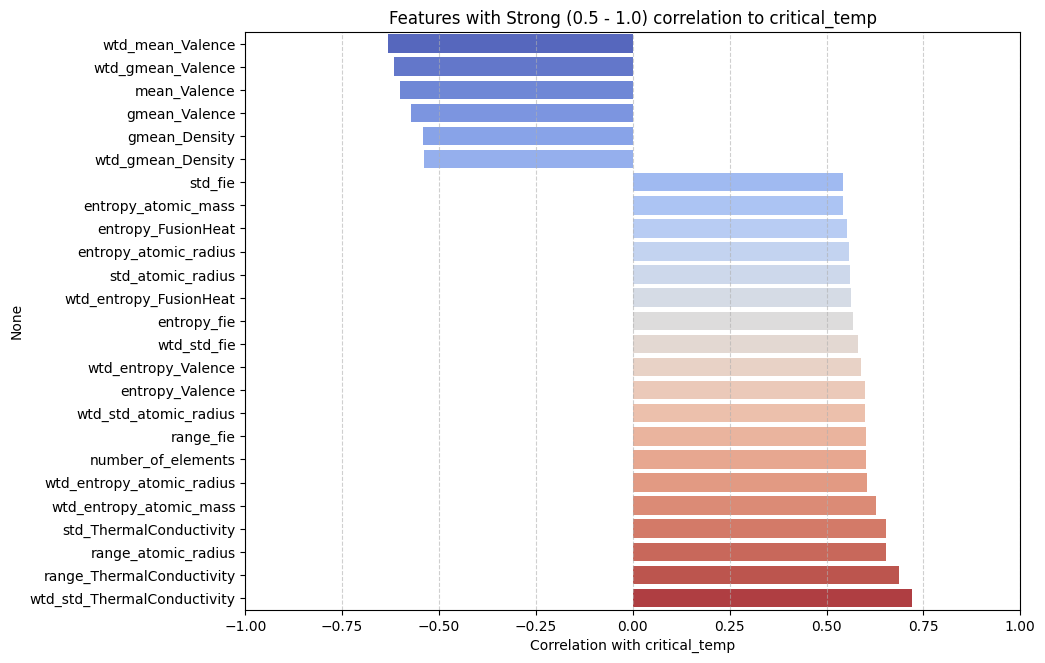

In [10]:
# Load dataset
def load_train_df(zip_url: str) -> pd.DataFrame:
    """
    Download the ZIP at `zip_url`, extract 'train.csv', and return it as a DataFrame.
    """
    resp = requests.get(zip_url)
    resp.raise_for_status()

    with zipfile.ZipFile(io.BytesIO(resp.content)) as z:
        with z.open('train.csv') as f:
            df = pd.read_csv(f)
    return df


# Example usage:
if __name__ == "__main__":
    url = "https://archive.ics.uci.edu/static/public/464/superconductivty+data.zip"
    df = load_train_df(url)
    print(df.head())

print(f"Dataset shape: {df.shape}")
df.head()

# 2.1 Missing values
missing_counts = df.isnull().sum()
print("Missing values per column:", missing_counts[missing_counts > 0])

# 2.2 Target distribution
plt.figure(figsize=(8, 4))
sns.histplot(df['critical_temp'], bins=50, kde=True)
plt.title("Distribution of Critical Temperature")
plt.xlabel("Critical Temperature (K)")
plt.ylabel("Count")
plt.tight_layout()

# 2.3 Correlation heatmap of top 15 features with target
corr_top15 = df.corr()['critical_temp'].abs(
).sort_values(ascending=False).iloc[1:16]
plt.figure(figsize=(10, 10))
sns.heatmap(df[corr_top15.index.tolist() + ['critical_temp']].corr(), annot=True,
            fmt=".2f", cmap='coolwarm', linecolor='white', linewidths=0.1)
plt.title("Top 15 Features Correlated with Critical Temperature")
plt.tight_layout()

# 2.4 Feature correlation with target


def plot_feature_correlation(df):
    """
    Plots the correlation of each feature with the target variable.
    """
    corr_with_target = df.corr()['critical_temp'].drop('critical_temp')
    abs_corr = corr_with_target.abs()

    intervals = {
        'Weak (0 - 0.2)': (0.0, 0.2),
        'Moderate (0.2 - 0.5)': (0.2, 0.5),
        'Strong (0.5 - 1.0)': (0.5, 1.0)
    }

    for interval_name, (low, high) in intervals.items():
        features_in_interval = corr_with_target[(
            abs_corr >= low) & (abs_corr < high)].sort_values()

        if features_in_interval.empty:
            print(f"No features in {interval_name} correlation interval.")
            continue

        plt.figure(figsize=(10, max(4, len(features_in_interval) * 0.3)))
        sns.barplot(x=features_in_interval.values,
                    y=features_in_interval.index, palette='coolwarm')
        plt.xlabel('Correlation with critical_temp')
        plt.title(
            f'Features with {interval_name} correlation to critical_temp')
        plt.xlim(-1, 1)
        plt.grid(axis='x', linestyle='--', alpha=0.6)
        plt.show()


plot_feature_correlation(df)

## 3. EDA & FEATURE ENGINEERING

- Multivariate outlier removal (IQR)
- Correlation filtering
- Feature importance via RandomForest


In [11]:
# 3.1 Outlier removal
def remove_outliers_iqr(df, k=1.5, min_features=2):
    df_out = df.copy()
    num_cols = df_out.select_dtypes(
        include=np.number).columns.drop('critical_temp')
    bounds = {}
    for col in num_cols:
        Q1, Q3 = df_out[col].quantile([.25, .75])
        IQR = Q3 - Q1
        bounds[col] = (Q1 - k*IQR, Q3 + k*IQR)
    mask = pd.DataFrame(False, index=df_out.index, columns=num_cols)
    for col, (low, up) in bounds.items():
        mask[col] = (df_out[col] < low) | (df_out[col] > up)
    drop_idx = mask.sum(axis=1).ge(min_features)
    print(
        f"Removing {drop_idx.sum()} rows with ≥{min_features} outlier features")
    return df_out.loc[~drop_idx]


df = remove_outliers_iqr(df)
print(f"Post-outlier shape: {df.shape}")

# 3.2 Correlation filtering
corr = df.corr().abs()
upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
to_drop = [c for c in upper.columns if any(upper[c] > 0.8)]
df = df.drop(columns=to_drop)
print(f"Dropped {len(to_drop)} high-corr features: {to_drop}")
print(f"Shape after corr-filtering: {df.shape}")

# 3.3 Feature importance (RF)
X_all = df.drop('critical_temp', axis=1)
y_all = df['critical_temp']
rf = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf.fit(X_all, y_all)
importances = pd.Series(rf.feature_importances_, index=X_all.columns)
top20 = importances.sort_values(ascending=False).head(20)
print("Top-20 RF importances:\n", top20)

Removing 9542 rows with ≥2 outlier features
Post-outlier shape: (11721, 82)
Dropped 55 high-corr features: ['gmean_atomic_mass', 'wtd_gmean_atomic_mass', 'entropy_atomic_mass', 'wtd_entropy_atomic_mass', 'std_atomic_mass', 'wtd_std_atomic_mass', 'wtd_mean_fie', 'gmean_fie', 'wtd_gmean_fie', 'entropy_fie', 'wtd_range_fie', 'std_fie', 'wtd_std_fie', 'wtd_mean_atomic_radius', 'gmean_atomic_radius', 'wtd_gmean_atomic_radius', 'entropy_atomic_radius', 'wtd_entropy_atomic_radius', 'range_atomic_radius', 'std_atomic_radius', 'wtd_std_atomic_radius', 'wtd_mean_Density', 'gmean_Density', 'wtd_gmean_Density', 'entropy_Density', 'std_Density', 'wtd_std_Density', 'gmean_ElectronAffinity', 'wtd_gmean_ElectronAffinity', 'entropy_ElectronAffinity', 'wtd_range_ElectronAffinity', 'std_ElectronAffinity', 'wtd_std_ElectronAffinity', 'mean_FusionHeat', 'wtd_mean_FusionHeat', 'gmean_FusionHeat', 'wtd_gmean_FusionHeat', 'entropy_FusionHeat', 'wtd_entropy_FusionHeat', 'wtd_range_FusionHeat', 'std_FusionHeat'

## 4. PREPROCESSING PIPELINE

- Impute missing → Scale → SelectKBest → PCA (95% variance)


After preprocessing: (11721, 14) features


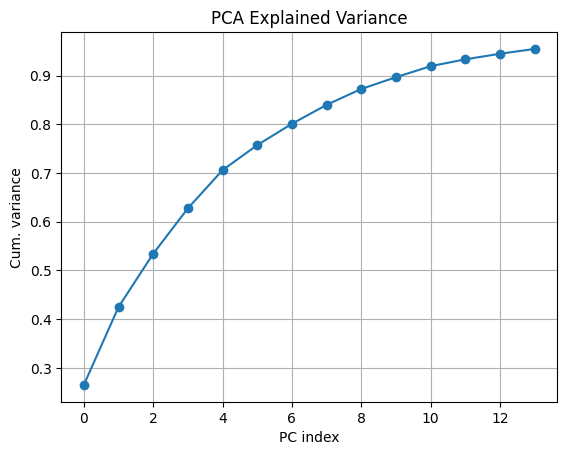

In [12]:
numeric_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])
select_k = SelectKBest(score_func=f_regression, k=50)
pca = PCA(n_components=0.95, random_state=42)

preprocessing = Pipeline([
    ('num', numeric_pipeline),
    ('kbest', select_k),
    ('pca', pca)
])

# Fit transform full data for reuse
X_pre = preprocessing.fit_transform(X_all, y_all)
print(f"After preprocessing: {X_pre.shape} features")
# Visualize explained variance
cumvar = np.cumsum(preprocessing.named_steps['pca'].explained_variance_ratio_)
plt.plot(cumvar, marker='o')
plt.xlabel('PC index')
plt.ylabel('Cum. variance')
plt.title('PCA Explained Variance')
plt.grid()
plt.show()

## 5. MODEL DEFINITION & HYPERPARAMETER SEARCH

Define pipelines and param grids for each model, then run RandomizedSearchCV.


In [13]:
# 5.1 Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X_all, y_all, test_size=0.2, random_state=42
)

In [ ]:
# 5.1 Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X_all, y_all, test_size=0.2, random_state=42
)


# 5.2 Models & parameter grids

model_defs = {
    'LinearRegression': {
        'model': LinearRegression(),
        'params': {}
    },

    'Ridge': {
        'model': Ridge(random_state=42),
        'params': {'model__alpha': [0.1, 1, 10, 100]}
    },

    'Lasso': {
        'model': Lasso(random_state=42, max_iter=5000),
        'params': {'model__alpha': [0.001, 0.01, 0.1, 1]}
    },

    'ElasticNet': {
        'model': ElasticNet(random_state=42, max_iter=5000),
        'params': {'model__alpha': [0.01, 0.1, 1], 'model__l1_ratio': [0.2, 0.5, 0.8]}
    },

    'SVR': {
        'model': SVR(),
        'params': {'model__C': [0.1, 1, 10], 'model__gamma': ['scale', 'auto'], 'model__kernel': ['rbf', 'linear']}
    },

    'DecisionTree': {

        'model': DecisionTreeRegressor(random_state=42),
        'params': {'model__max_depth': [None, 5, 10, 20], 'model__min_samples_leaf': [1, 5, 10]}

    },

    'RandomForest': {

        'model': RandomForestRegressor(random_state=42, n_jobs=-1),
        'params': {'model__n_estimators': [100, 200], 'model__max_depth': [None, 10, 20]}
    },

    'GradientBoosting': {
        'model': GradientBoostingRegressor(random_state=42),
        'params': {'model__n_estimators': [100, 200], 'model__learning_rate': [0.01, 0.1], 'model__max_depth': [3, 5]}
    },

    'XGBoost': {
        'model': XGBRegressor(random_state=42, n_jobs=-1, verbosity=0),
        'params': {'model__n_estimators': [100, 200], 'model__learning_rate': [0.01, 0.1], 'model__max_depth': [3, 6]}
    },

    'LightGBM': {
        'model': lgb.LGBMRegressor(random_state=42, n_jobs=-1),
        'params': {'model__n_estimators': [100, 200], 'model__learning_rate': [0.01, 0.1], 'model__num_leaves': [31, 50]}
    }
}


# 5.3 Run searches

results = []
cv = KFold(n_splits=5, shuffle=True, random_state=42)

for name, defn in model_defs.items():
    pipe = Pipeline([
        ('preproc', preprocessing),
        ('model', defn['model'])
    ])

    search = RandomizedSearchCV(
        pipe,
        defn['params'],
        n_iter=10,
        scoring='neg_root_mean_squared_error',
        cv=cv,
        random_state=42,
        n_jobs=-1,
        verbose=1
    )

    print(f"Training & tuning {name}...")
    search.fit(X_train, y_train)
    y_pred = search.predict(X_test)
    # Compute RMSE as sqrt of MSE
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    results.append({
        'Model': name,
        'BestParams': search.best_params_,
        'Test RMSE': rmse,
        'Test R²': r2

    })

Training & tuning LinearRegression...
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Training & tuning Ridge...
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Training & tuning Lasso...
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Training & tuning ElasticNet...
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Training & tuning SVR...
Fitting 5 folds for each of 10 candidates, totalling 50 fits


## 6. MODEL PERFORMANCE COMPARISON


In [ ]:
results_df = pd.DataFrame(results).sort_values(
    'Test RMSE').reset_index(drop=True)
results_df

,Model,BestParams,Test RMSE,Test R²
0,LightGBM,"{'model__num_leaves': 50, 'model__n_estimators...",12.507629,0.855644
1,RandomForest,"{'model__n_estimators': 200, 'model__max_depth...",12.515190,0.855469
2,XGBoost,"{'model__n_estimators': 200, 'model__max_depth...",12.731868,0.850421
3,GradientBoosting,"{'model__n_estimators': 200, 'model__max_depth...",13.895277,0.821836
4,DecisionTree,"{'model__min_samples_leaf': 5, 'model__max_dep...",15.859696,0.767900
5,SVR,"{'model__kernel': 'rbf', 'model__gamma': 'auto...",16.920999,0.735797
6,ElasticNet,"{'model__l1_ratio': 0.8, 'model__alpha': 0.01}",22.543166,0.531061
7,Ridge,{'model__alpha': 10},22.543458,0.531049
8,Lasso,{'model__alpha': 0.001},22.543645,0.531041
9,LinearRegression,{},22.543669,0.531040


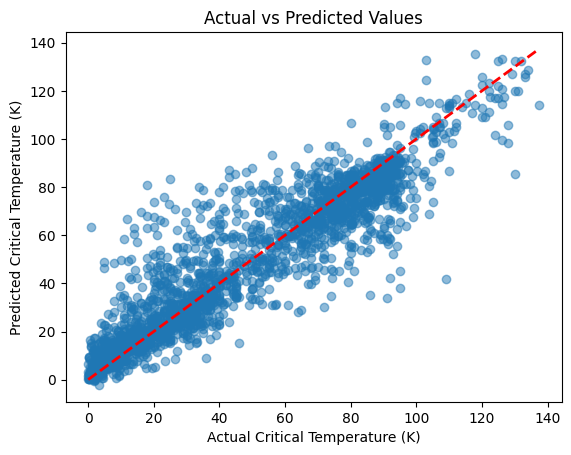

In [ ]:
# Plot Actual vs Predicted
plt.figure()
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()], "--r", linewidth=2)
plt.xlabel("Actual Critical Temperature (K)")
plt.ylabel("Predicted Critical Temperature (K)")
plt.title("Actual vs Predicted Values")
plt.show()

## 7. FINAL RESULTS & DISCUSSION

- The table above ranks all models by test RMSE.
- Inspect the **BestParams** column for each.
- Choose the top performer for further analysis or deployment.


| index | Model            | BestParams                                                                                  | Test RMSE           | Test R²             |
| ----- | ---------------- | ------------------------------------------------------------------------------------------- | ------------------- | ------------------- |
| 0     | LightGBM         | \{'model\_\_num_leaves': 50, 'model\_\_n_estimators': 200, 'model\_\_learning_rate': 0\.1\} | 12\.507628559116899 | 0\.855643568952114  |
| 1     | RandomForest     | \{'model\_\_n_estimators': 200, 'model\_\_max_depth': None\}                                | 12\.515189792196097 | 0\.8554689806930561 |
| 2     | XGBoost          | \{'model\_\_n_estimators': 200, 'model\_\_max_depth': 6, 'model\_\_learning_rate': 0\.1\}   | 12\.731867930734646 | 0\.8504210654487008 |
| 3     | GradientBoosting | \{'model\_\_n_estimators': 200, 'model\_\_max_depth': 5, 'model\_\_learning_rate': 0\.1\}   | 13\.895276705377755 | 0\.8218357415331826 |
| 4     | DecisionTree     | \{'model\_\_min_samples_leaf': 5, 'model\_\_max_depth': None\}                              | 15\.85969645836324  | 0\.7678995793788652 |
| 5     | SVR              | \{'model\_\_kernel': 'rbf', 'model\_\_gamma': 'auto', 'model\_\_C': 10\}                    | 16\.920999363721908 | 0\.7357967207330662 |
| 6     | ElasticNet       | \{'model\_\_l1_ratio': 0\.8, 'model\_\_alpha': 0\.01\}                                      | 22\.543166449154626 | 0\.5310613586288413 |
| 7     | Ridge            | \{'model\_\_alpha': 10\}                                                                    | 22\.543458172556    | 0\.5310492218013951 |
| 8     | Lasso            | \{'model\_\_alpha': 0\.001\}                                                                | 22\.54364534173419  | 0\.531041434753333  |
| 9     | LinearRegression | \{\}                                                                                        | 22\.54366943088617  | 0\.5310404325356336 |


### Key Takeaways

- **Linear vs. Nonlinear**: Nonlinear tree and boosting models (e.g., XGBoost, LightGBM) often outperform linear models.
- **Hyperparameter Tuning**: Even modest grids yield significant gains.
- **Reproducibility**: All seeds fixed; pipeline encapsulates preprocessing.
